In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import random
import math
import cv2

In [2]:
from collections import namedtuple
Circle = namedtuple('Circle', ['x', 'y', 'r', 'O', 'c'])
Rectangle = namedtuple('Rectangle', ['x', 'y', 'k', 'a', 'b', 'O', 'c'])
# x & y : any float (location of center of the obstacle)
# r: radius of circle
# k: angle of the rectangle (0 to pi/2)
# a, b: sides of the rectangle
# O, c: opacity and color of the obstacle

# color_map, polar_map -> uint8 array
# opacity_map -> bool array

class actor:
    def __init__(self, map_size, initial_location = None):
        self.map_size = map_size
        self.opacity_map = np.full((map_size, map_size), False)
        self.color_map = np.zeros([map_size, map_size], dtype = np.uint8);
        self.initial_location = initial_location if (initial_location != None) else (int(map_size/2),int(map_size/2))
        self.Y,self.X = np.meshgrid(np.linspace(1, self.map_size ,self.map_size),np.linspace(1, self.map_size ,self.map_size))
        self.x = int(map_size/2)
        self.y = int(map_size/2)
        self.polar_angle_size = 256
        self.polar_dist_size = 256
        self.n_circles = 20
        self.n_rectangles = 20
        self.polar_map = np.zeros([self.polar_dist_size, self.polar_angle_size], dtype = np.uint8)
        self.view = np.zeros([self.polar_angle_size])
        self.depth = np.zeros([self.polar_angle_size])
    def initialize_terrain(self):
        A = [Circle(x = random.randrange(0, self.map_size), 
                    y = random.randrange(0, self.map_size), 
                    r = random.randrange(0, int(self.map_size/2)), 
                    O = bool(random.getrandbits(1)), 
                    c = random.randrange(1, 255)) for i in range(self.n_circles)]
        A += [Rectangle(x = random.randrange(0, self.map_size), 
                        y = random.randrange(0, self.map_size), 
                        k = random.uniform(0, math.pi/2), 
                        a = random.uniform(0, self.map_size), 
                        b = random.uniform(0, self.map_size), 
                        O = bool(random.getrandbits(1)), 
                        c = random.randrange(1, 255)) for j in range(self.n_rectangles)]
        self.generate_terrain(A)
    def generate_terrain(self, A):
        for i in A:
            if type(i).__name__ == 'Circle':
                mask = self.circular_obstacle(i)
            elif type(i).__name__ == 'Rectangle':
                mask = self.rectangular_obstacle(i)
            if not (mask & (self.circular_obstacle(Circle(x = self.x, y = self.y, r = 16, O = True, c = 255)).astype(bool))).any():
                if i.O:
                    self.opacity_map = np.logical_or(mask, self.opacity_map)
                    self.color_map = self.color_map*(~mask)+(i.c*mask).astype(np.uint8)
                else:
                    self.opacity_map = np.logical_and(~mask, self.opacity_map)
                    self.color_map = self.color_map*(~mask)
    def generate_view(self):
        self.padded_map = cv2.copyMakeBorder(self.color_map, self.map_size*2, self.map_size*2, self.map_size*2, self.map_size*2, cv2.BORDER_CONSTANT, 0)
        self.polar_map = cv2.warpPolar(self.padded_map, self.polar_map.shape, (self.map_size*2+self.y,self.map_size*2+self.x), 256, flags = cv2.INTER_NEAREST+cv2.WARP_POLAR_LINEAR)
        self.polar_map = np.flip(np.roll(self.polar_map, -int(self.map_size/4), axis = 0), axis = 0)
        mask = self.polar_map!=0
        self.depth = np.where(mask.any(axis=1), mask.argmax(axis=1), 0)
        self.view = self.polar_map[np.arange(self.polar_angle_size), self.depth]
    def circular_obstacle(self, i):
        return (self.X-i.x)**2 + (self.Y-i.y)**2 <= i.r**2
    def rectangular_obstacle(self, i):
        return  np.logical_and((np.abs((self.X-i.x)/(np.cos(i.k)+0.001)-(self.Y-i.y)/(np.sin(i.k)+0.001)))<=(i.a*np.abs(np.tan(i.k)+1/(np.tan(i.k)+0.001))/2),
                               (np.abs((self.X-i.x)/(np.sin(i.k)+0.001)+(self.Y-i.y)/(np.cos(i.k)+0.001)))<=(i.b*np.abs(np.tan(i.k)+1/(np.tan(i.k)+0.001))/2))



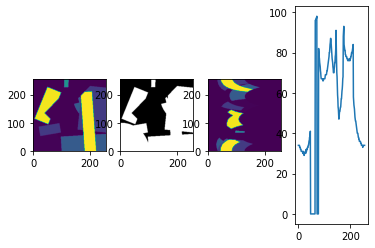

In [3]:
a = actor(256)
A = [Rectangle(x = 50, y = 40, k = 0.5, a = 40, b = 40, O = True, c = 80),
     Rectangle(x = 80, y = 20, k = 0.0, a = 40, b = 40, O = False, c = 28),
     Rectangle(x = 180, y = 90, k = 0.8, a = 100, b = 10, O = True, c = 50),
     Circle(x = 130, y = 230, r = 80, O = True, c = 30),
     Circle(x = 100, y = 90, r = 40, O = True, c = 200),
     Circle(x = 30, y = 130, r = 20, O = True, c = 50),]
a.initialize_terrain()
#a.generate_terrain(A)
plt.subplot(1,4,1)
plt.imshow(a.color_map.T)
plt.xlim(0,256)
plt.ylim(0,256)
plt.subplot(1,4,2)
plt.imshow(a.opacity_map.T, cmap='gray')
plt.xlim(0,256)
plt.ylim(0,256)
plt.subplot(1,4,3)

a.generate_view()
plt.imshow(a.polar_map)
plt.xlim(0,256)
plt.ylim(0,256)
plt.subplot(1,4,4)
plt.plot(a.depth)
plt.show()

In [4]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
fig = plt.figure()
plt.subplot(2,1,1)
im1 = plt.imshow(np.tile(a.view.reshape(1,256), (50,1)), vmin=0, vmax=256)
plt.xlim(0,256)
plt.ylim(0,50)
print(a.view)
plt.subplot(2,1,2)
im2 = plt.imshow(a.color_map.T, vmin=0, vmax=256)
plt.xlim(0,256)
plt.ylim(0,256)
pos = plt.scatter([a.x],[a.y],color='r')
plt.xlim(0,256)
plt.ylim(0,256)
              
def init():
    plt.subplot(2,1,1)
    im1 = plt.imshow(np.tile(a.view.reshape(1,256), (50,1)), vmin=0, vmax=256)
    plt.subplot(2,1,2)
    pos = plt.scatter([a.x],[a.y],color='r')
    return [im1]

def animate(frame_num):
    if a.y < a.map_size and a.y >= 0:
        a.y-=1
    a.generate_view()
    plt.subplot(2,1,1)
    im1 = plt.imshow(np.tile(a.view.reshape(1,256), (50,1)), vmin=0, vmax=256)
    plt.subplot(2,1,2)
    pos = plt.scatter([a.x],[a.y],color='r')
    return [im1, pos]
                
anim = FuncAnimation(fig, animate, frames=100, interval=1)
plt.show()

<IPython.core.display.Javascript object>

[ 37  37  37  37  37  62  62  62  62  62  62  62  62  62  62  62  62  62
  62  62  62  62  62  62  62  62  62  62  62  62  62  62  62  62  62  62
  62  62  62  62  62  62  62  62  62  62  62   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0 111 111 111 111 111 111 111
   0   0   0   0   0   0 209 209 209 209 209 209 209 209 209 209 209 209
 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209
 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209
 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209 209
 209  36  36  36  36  36  36  36  36  36  36  36  36  36  36  36  36  36
  36  36  36  36  36  36  36  36  36  36  36   2   2   2  61  61  61  61
  61  61  61  61  61  61  61  61  61  61  61  61  61  61  61  61  61  61
  61  61  61  61  61  61  61  61  61  61  61  61  61  61  37  37  37  37
  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37  37
  37  37  37  37  37  37  37  37  37  37  37  37  3

In [28]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as f

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [82]:
class Nerf_Model(nn.Module):
    def __init__(self, map_size, view_size):
        super().__init__()
        self.occupancy = nn.Sequential(nn.Linear(32, 32),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(32, 32),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(32, 33),
                                       nn.ReLU(inplace=True))
        self.color = nn.Sequential(nn.Linear(32,32),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(32, 1),
                                   nn.Sigmoid())
        self.map_size = map_size
        self.view_size = view_size
    
    def forward(self, p):
        X = self.positional_encoder(p)
        X = self.occupancy(X)
        o = X[:,:1]
        c = self.color(X[:,1:])
        return torch.cat([o, c], dim = 1)
        
        
    def positional_encoder(self, P):
        P = P.reshape((-1, 2, 1)).tile(1,1,8)
        w = 2 ** torch.linspace(0, 7, steps=8, device=device).tile(P.shape[0],2,1)
        P *= math.pi * w
        P = torch.cat([torch.cos(P), torch.sin(P)], dim = 2)
        return P.reshape(P.shape[0],-1)
        
M = Nerf_Model(256, 256).to(device);
print(M(torch.tensor([[0.28, 0.382], [0.01,0.01],[0, 0],[0, 0],[0.01,0.01]], device=device)))

tensor([[0.0000, 0.5296],
        [0.0000, 0.5301],
        [0.0000, 0.5273],
        [0.0000, 0.5273],
        [0.0000, 0.5301]], device='cuda:0', grad_fn=<CatBackward0>)


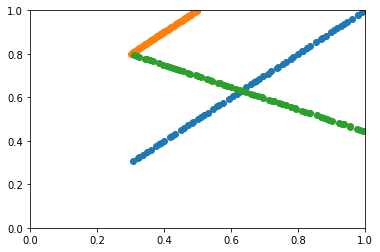

In [83]:
N = 64

#ray point sampling


def end_point(p, a):
    r = 2 * math.pi * (a)
    smooth = 10**-6
    x = p[:,0]
    y = p[:,1]
    T = torch.stack([-x/(torch.cos(r)+smooth), 
                     -y/(torch.sin(r)+smooth), 
                     (1-x)/(torch.cos(r)+smooth), 
                     (1-y)/(torch.sin(r)+smooth)])
    T = torch.min(torch.where(T>=0, T, 10*torch.ones(T.shape, device = device)), 0)[0]
    return torch.stack([x + T * torch.cos(r), y + T * torch.sin(r)]).T

def rand_samp(p):
    p, a = p[:,:2], p[:,2]
    p_e = end_point(p, a)
    p_e = p_e[:,:2]
    p_i = torch.linspace(0, N-1, N, device=device)
    p_i = p_i.reshape((1, N, 1)) * (p_e-p).reshape((p.shape[0], 1, 2)) / N
    randn = torch.rand(p.shape[0],N, device=device)
    p_i = p_i + randn.reshape((p.shape[0],N,1)) * (p_e-p).reshape((p.shape[0], 1, 2)) / N
    return p_i + p.reshape(p.shape[0],1,2)

p = rand_samp(torch.tensor([[0.3,0.3,0.125], [0.3,0.8,0.125],[0.3,0.8,0.925], [0.3,0.8,0.925]], device=device)).to('cpu')
plt.scatter(p[0,:,0],p[0,:,1])
plt.scatter(p[1,:,0],p[1,:,1])
plt.scatter(p[2,:,0],p[2,:,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [84]:
# p: [[c,x,y,r],...[c,x,y,r]]
criterion = nn.MSELoss()
def photo_loss(model, p):
    rand_points = rand_samp(p[:,1:])
    output = model(torch.squeeze(rand_points,dim = 1)).reshape((-1, N, 2))
    dists = (torch.roll(rand_points, -1, 1) - torch.roll(rand_points, 1, 1))/2
    dists[:,0,:] = (rand_points[:,-1]-rand_points[:,0])/(rand_points.shape[1]-1)
    dists[:,-1,:] = (rand_points[:,-1]-rand_points[:,0])/(rand_points.shape[1]-1)
    dist = (dists[:,:,0]**2 + dists[:,:,1]**2)**0.5
    sigma = torch.tril(torch.ones((N,N), device=device),diagonal=-1)
    T = torch.exp(-torch.matmul(sigma, (output[:,:,0]*dist).T).T)
    #print(T)
    C = T * (1 - torch.exp(-output[:,:,0] * dist)) * output[:,:,1]
    #print(output[:,:,1])
    C = torch.sum(C, dim = 1)
    loss = criterion(C, p[:,0])
    #print(C)
    return loss
photo_loss(M,torch.tensor([[0.1,0.3,0.3,0.125],[0.1,0.3,0.8,0.125],[0.1,0.3,0.8,0.125]], device=device))

tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

In [85]:
a = torch.tensor([[0.,0.,0.,0.],[0.5,0.5,0.5,0.5],[0.5,0.5,0.5,0.5]], device=device)
photo_loss(M, a)

tensor(0.1658, device='cuda:0', grad_fn=<MseLossBackward0>)

In [86]:
def gen_viewpoints(actor, n_sample):
    samplecount = 0
    viewpoints = torch.tensor([])
    while samplecount < n_sample:
        actor.x, actor.y = random.randint(0, actor.map_size-1), random.randint(0, actor.map_size-1)
        if actor.opacity_map[a.x,a.y] == False:
            samplecount += 1
            actor.generate_view()
            view = torch.cat([torch.from_numpy(actor.view.reshape((-1,1)))/256, 
                                torch.tensor([a.x]).expand(256,1)/256, 
                                torch.tensor([a.y]).expand(256,1)/256, 
                                torch.linspace(0,1,256).reshape(256,1)], dim = 1)
            viewpoints = torch.cat([viewpoints, view])
    return viewpoints.to(device)

def train(model, n, n_batch, p, optim):
    optim.zero_grad()
    #print(torch.index_select(p, 0, torch.randint(0, p.shape[0], (n_batch,))))
    for i in range(n):
        loss = photo_loss(model, torch.index_select(p, 0, torch.randint(0, p.shape[0], (n_batch,), device=device)))
        loss.backward()
        optim.step()
    return loss.item()


In [87]:
import wandb

wandb.init(project="Robovision", entity="gyungmin")

ModuleNotFoundError: No module named 'wandb'

In [88]:
learning_rate = 1*10**-5
n_epoch = 10000
model = Nerf_Model(256, 256).to(device)
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)

a = actor(256);
a.initialize_terrain()

In [94]:
model.train()
sum = 0
for i in range(n_epoch):
    p = gen_viewpoints(a, 64)
    loss = train(model, 20, 512, p, optim)
    sum += loss
    if i%100 == 0:
        print(sum/100)
        sum = 0
    
    #wandb.log({"loss": loss})

2.535861451178789e-05
0.00436175080598332
0.004166377014480531
0.004440395691199228
0.004316028309985996
0.004424849234055728
0.004411677769385278
0.004224080808926374
0.004410108318552375
0.00424059679498896
0.004481702025514096
0.004399427177850157
0.004371786504052579
0.004444811411667615
0.004098926376318559
0.004282419371884316
0.0043100464798044415
0.004211270390078426
0.004295114659471438
0.004267746398691088
0.004155266298912465
0.004393405209993944
0.004113960384856909
0.004317016935674474
0.004321049730060622
0.0042170853284187616
0.004365058331750334
0.004126002283301205
0.004340225758496672
0.004186274677049368
0.003974776398390532
0.004069452566327527
0.004126232787966728
0.003958340305835009
0.0036831776646431536
0.003985832135658712
0.004077082443982363
0.004271005231421441
0.003982631480321288
0.004047128587262705
0.004088517630007118
0.004072261587716639
0.0041173175279982386
0.004199013957986608
0.004132049882318824
0.004023104540538043
0.004091905169188976
0.00408029

KeyboardInterrupt: 

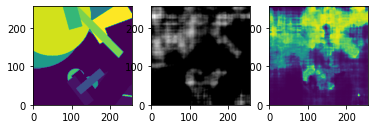

In [95]:
model.eval()
pred = torch.zeros((256,256,2), device=device)
for i in range(256):
    for j in range(256):
        #print(model(torch.tensor([[i/256,j/256]])).shape)
        pred[i,j] = model(torch.tensor([[i/256,j/256]], device=device))[0]

plt.subplot(1,3,1)
plt.imshow(a.color_map.T)
plt.xlim(0,256)
plt.ylim(0,256)
plt.subplot(1,3,2)
plt.imshow(pred.detach().to('cpu').numpy()[:,:,0].T, cmap = 'gray')
plt.xlim(0,256)
plt.ylim(0,256)
plt.subplot(1,3,3)
plt.imshow(pred.detach().to('cpu').numpy()[:,:,1].T)
plt.xlim(0,256)
plt.ylim(0,256)
plt.show()

In [59]:
a.x, a.y = 150, 200
a.generate_view()
view = torch.cat([torch.from_numpy(a.view.reshape((-1,1)))/256, 
                  torch.tensor([a.x]).expand(256,1)/256, 
                  torch.tensor([a.y]).expand(256,1)/256, 
                  torch.linspace(0,1,256).reshape(256,1)], dim = 1)
print(view.reshape((1,256,4)).shape)
rand_points = rand_samp(view[:,1:])
output = model(torch.squeeze(rand_points,dim = 1)).reshape((-1, N, 2))
dists = (torch.roll(rand_points, -1, 1) - torch.roll(rand_points, 1, 1))/2
dists[:,0,:] = (rand_points[:,-1]-rand_points[:,0])/(rand_points.shape[1]-1)
dists[:,-1,:] = (rand_points[:,-1]-rand_points[:,0])/(rand_points.shape[1]-1)
dist = (dists[:,:,0]**2 + dists[:,:,1]**2)**0.5
sigma = torch.tril(torch.ones((N,N)),diagonal=-1)
T = torch.exp(-torch.matmul(sigma, (output[:,:,0]*dist).T).T)
C = T * (1 - torch.exp(-output[:,:,0] * dist)) * output[:,:,1]
C = torch.sum(C, dim = 1)
plt.subplot(2,1,1)
im1 = plt.imshow(np.tile(C.detach().numpy().reshape(1,256), (50,1)), vmin=0, vmax=1)
plt.xlim(0,256)
plt.ylim(0,50)
plt.subplot(2,1,2)
im1 = plt.imshow(np.tile(a.view.reshape(1,256), (50,1)), vmin=0, vmax=256)
plt.xlim(0,256)
plt.ylim(0,50)

torch.Size([1, 256, 4])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!